# 数据导入

In [1]:
# 库导入
import pandas as pd
import jieba         # 中文分词
import re            # 用于正则表达式过滤
# from tqdm import tqdm_notebook   # notebook进度条
from sklearn.model_selection import train_test_split
import csv

In [2]:
# 导入数据
data = pd.read_excel("ProcessedData.xlsx", names=["电影名","地区","类型","评分","影评投票数","影评"]).astype(str)
# 获得评论和得分
comments, score, movie_score = data.values[:,5], data.values[:,4], data.values[:,3]
data.head()

,电影名,地区,类型,评分,影评投票数,影评
0,肖申克的救赎,?美国?,?犯罪 剧情,5,17847,当年的奥斯卡颁奖礼上，被如日中天的《阿甘正传》掩盖了它的光彩，而随着时间的推移，这部电影在越...
1,肖申克的救赎,?美国?,?犯罪 剧情,5,30399,不需要女主角的好电影
2,肖申克的救赎,?美国?,?犯罪 剧情,5,19203,恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》
3,肖申克的救赎,?美国?,?犯罪 剧情,5,14917,策划了19年的私奔……
4,肖申克的救赎,?美国?,?犯罪 剧情,3,1897,"在我的心目中,它一直都是最被高估的电影。"


In [3]:
# 获得电影名与电影类型用于停用词
movie_name = data.values[:,0]
movie_type = []
for i in data.values[:,3]:
    movie_type += (i.replace('\xa0','').replace('\n'+' '*24,'').split(' '))
movie_name, movie_type = list(set(movie_name)), list(set(movie_type))
movie_name, movie_type

def load_stopwords(words, filename):
    """从词库加载停用词"""
    with open(f'./stopwords/{filename}','r',encoding='UTF-8') as f:
        for line in f.readlines():
            if line.strip('\n') not in words:
                words.append(line.strip('\n'))
stopwords = []
load_stopwords(stopwords, "stopwords1.txt")
load_stopwords(stopwords, "stopwords2.txt")
load_stopwords(stopwords, "stopwords3.txt")
load_stopwords(stopwords, "stopwords4.txt")
# 停用词库中加上电影名和电影类型
stopwords += movie_name + movie_type + ["电影"]
len(stopwords)

def comment_word_cut(text_list, score, stopwords):
    """对句子做中文分词"""
    result, label = [], []
    # for index in tqdm_notebook(range(len(text_list))):
    for index in range(len(text_list)):
        # 去除特殊符号
        text_list[index] = re.sub("[0-9a-zA-Z\-\s+\.\!\/_,$%^*\(\)\+(+\"\')]+|[+——！，。？、~@#￥%……&*（）<>\[\]:：★◆【】《》;；=?？]+", "",
                                  text_list[index]).strip()
        # 中文分词
        seg_list = jieba.cut(text_list[index], cut_all=False, HMM=True)
        seg_list = [x.strip('\n')
                    for x in seg_list if x not in stopwords and len(x) > 1]
        if len(seg_list) > 1:
            result.append(seg_list)
            # 添加得分对应的正、反、中标签
            if score[index] <= "2":
                label.append(-1)
            elif score[index] >= "4":
                label.append(1)
            else:
                label.append(0)
    return result, label

In [4]:
# 数据集划分与分词
x_train, x_test, y_train, y_test = train_test_split(comments, movie_score, test_size=0.2, random_state=0)
train_word_cut, train_label = comment_word_cut(comments, movie_score, stopwords)
test_word_cut, test_label = comment_word_cut(x_test, y_test, stopwords)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\z2000\AppData\Local\Temp\jieba.cache
Loading model cost 0.542 seconds.
Prefix dict has been built successfully.


In [5]:
# 生成索引词典
vocabulary = train_word_cut + test_word_cut
word2index = {}
vocabulary_count = 0
for v in vocabulary:
    for w in v:
        if w not in word2index:
            word2index[w] = vocabulary_count
            vocabulary_count += 1
print("vocabulary size: {}".format(vocabulary_count))

vocabulary size: 76840


In [6]:
# 根据索引词典Word2index
train_index = []
for w in train_word_cut:
    train_index.append([word2index[v] for v in w])
test_index = []
for w in test_word_cut:
    test_index.append([word2index[v] for v in w])

# 分类模型

In [7]:
# 库导入
# 使用keras搭建模型
from keras.preprocessing import sequence
from keras.models import Sequential, Model # 序列模型和通用模型
from keras.models import load_model
from keras.layers import Dense, Embedding, Dropout, LSTM
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Concatenate
from keras.callbacks import ModelCheckpoint # 获取效果最好的模型
import numpy as np

In [8]:
max_features = vocabulary_count # 特征维度即index维度
# 将序列转化为经过填充以后的一个长度相同的新序列新序列
# maxlen句子的词汇最大长度(不足时在句子前补0)
train_index = sequence.pad_sequences(train_index, maxlen=120)
test_index = sequence.pad_sequences(test_index, maxlen=120)
train_index = np.array(train_index)
train_label = np.array(train_label)
test_index = np.array(test_index)
test_label = np.array(test_label)

## 基于Sequential的LSTM训练模型

In [9]:
# 创建模型
model = Sequential([
    Embedding(max_features, 128),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='softmax'),
    Dense(1, activation='sigmoid'),
])
# 编译模型
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='acc')
# 模型概要
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         9835520   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 9,971,265
Trainable params: 9,971,265
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_path = './models/model1-{epoch:02d}.hdf5'
checkpointer = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
model.fit(train_index, train_label, batch_size=32, epochs=30, validation_data=(test_index, test_label), callbacks=[checkpointer]) # batch_size批处理大小，epochs训练轮数，initial_epoch开始训练轮数

Epoch 1/30
1445/1445 [==============================] - 390s 251ms/step - loss: 0.5767 - acc: 0.8205 - val_loss: 0.5481 - val_acc: 0.8257

Epoch 00001: saving model to ./models\model1-01.hdf5
Epoch 2/30
1445/1445 [==============================] - 369s 256ms/step - loss: 0.5497 - acc: 0.8238 - val_loss: 0.5481 - val_acc: 0.8257

Epoch 00002: saving model to ./models\model1-02.hdf5
Epoch 3/30
1445/1445 [==============================] - 356s 246ms/step - loss: 0.5502 - acc: 0.8220 - val_loss: 0.5481 - val_acc: 0.8257

Epoch 00003: saving model to ./models\model1-03.hdf5
Epoch 4/30
1445/1445 [==============================] - 368s 254ms/step - loss: 0.5537 - acc: 0.8206 - val_loss: 0.5481 - val_acc: 0.8257

Epoch 00004: saving model to ./models\model1-04.hdf5
Epoch 5/30
1445/1445 [==============================] - 352s 244ms/step - loss: 0.5520 - acc: 0.8214 - val_loss: 0.5480 - val_acc: 0.8257

Epoch 00005: saving model to ./models\model1-05.hdf5
Epoch 6/30
1445/1445 [==================

290/290 [==============================] - 5s 14ms/step - loss: -1.1408 - acc: 0.9260


(array([0.07372176], dtype=float32),
 0.9283320722084099,
 -1.1408004760742188,
 0.9259539246559143,
 0.9853053434494595)

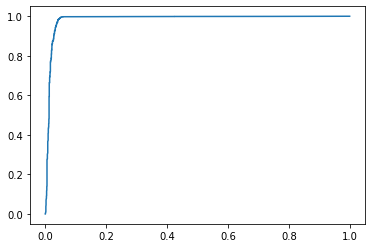

In [35]:
# # x_train3, x_test3, y_train3, y_test3 = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
# # test_word_cut3, test_label3 = comment_word_cut(x_test3, y_test3, stopwords)
# # test_index3 = []
# # for w in test_word_cut3:
# #     test_index3.append([word2index[v] for v in w])
# # test_index3 = sequence.pad_sequences(test_index3, maxlen=120)
# # test_index3 = np.array(test_index3)
from sklearn.metrics import roc_curve, roc_auc_score, auc, plot_roc_curve
# # 预测
modelnew1 = load_model('./models/model1-29.hdf5')
predict_label = modelnew1.predict(test_index)
acc = 0.0
# acc2 = 0.0
loss = 0.0
#predict_labelmy = []
for i in range(0,len(predict_label)):
    # print(test_label[i])
    # print(predict_label[i])
    if predict_label[i] < 1.2803e-09:
        predict_label[i] = -1
    elif predict_label[i] < 0.76445735:
        predict_label[i] = 0
    else:
        predict_label[i] = 1
    # print(predict_label[i])
    # if test_label[i] == 1:
    #     acc2 += 1
    if predict_label[i] == test_label[i]:
        acc += 1
    if predict_label[i] > test_label[i]:
        loss += predict_label[i] - test_label[i]
    else:
        loss += test_label[i] - predict_label[i]
# # 评估模型
loss2, accuracy2 = modelnew1.evaluate(test_index, test_label, batch_size=32)
loss = loss/len(predict_label)
acc = acc/len(predict_label)
predict_label = np.array(predict_label)
#auc1 = roc_auc_score(test_label,predict_label,multi_class='ovo')
# acc2 = acc2/len(predict_label)
fpr,tpr,thr = roc_curve(test_label,modelnew1.predict(test_index), pos_label=1)
auc1 = auc(fpr,tpr)
plt.plot(fpr,tpr)
loss, acc, loss2, accuracy2, auc1

## 基于Model的TextCNN训练模型

In [12]:
# 创建模型
input = Input(shape=(120,))
embedding = Embedding(max_features, 256, input_length=120)(input) # 嵌入
convs = []
for kernel_size in [3, 4, 5]:
    conv = Conv1D(256, kernel_size, activation='relu')(embedding) # 卷积
    conv = GlobalMaxPooling1D()(conv) # 池化
    convs.append(conv)
x = Concatenate()(convs) # 连接
dense = Dense(64, activation='softmax')(x)
output = Dense(1, activation="sigmoid")(dense)
model2 = Model(inputs=input, outputs=output)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 120, 256)     19671040    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 118, 256)     196864      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 117, 256)     262400      embedding_1[0][0]                
______________________________________________________________________________________________

In [13]:
# 模型训练和预测
model_path2 = './models/model2-{epoch:02d}.hdf5'
checkpointer2 = ModelCheckpoint(model_path2, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
# train_index2 = np.array(train_index2)
# train_label2 = np.array(train_label2)
# test_index2 = np.array(test_index2)
# test_label2 = np.array(test_label2)
# model2.fit(train_index2, train_label2, batch_size=32, epochs=2, validation_data=(test_index2, test_label2), callbacks=[checkpointer2])
model2.fit(train_index, train_label, batch_size=32, epochs=30, validation_data=(test_index, test_label), callbacks=[checkpointer2])

Epoch 1/30
1445/1445 [==============================] - 408s 279ms/step - loss: 0.5794 - acc: 0.8224 - val_loss: 0.5481 - val_acc: 0.8257

Epoch 00001: saving model to ./models\model2-01.hdf5
Epoch 2/30
1445/1445 [==============================] - 411s 285ms/step - loss: 0.5548 - acc: 0.8211 - val_loss: 0.5480 - val_acc: 0.8257

Epoch 00002: saving model to ./models\model2-02.hdf5
Epoch 3/30
1445/1445 [==============================] - 398s 275ms/step - loss: 0.5464 - acc: 0.8248 - val_loss: 0.5480 - val_acc: 0.8257

Epoch 00003: saving model to ./models\model2-03.hdf5
Epoch 4/30
1445/1445 [==============================] - 414s 286ms/step - loss: 0.5510 - acc: 0.8223 - val_loss: 0.5480 - val_acc: 0.8257

Epoch 00004: saving model to ./models\model2-04.hdf5
Epoch 5/30
1445/1445 [==============================] - 409s 283ms/step - loss: 0.5522 - acc: 0.8213 - val_loss: 0.5480 - val_acc: 0.8257

Epoch 00005: saving model to ./models\model2-05.hdf5
Epoch 6/30
1445/1445 [==================

290/290 [==============================] - 7s 24ms/step - loss: 0.5481 - acc: 0.8257


(0.5481305122375488, 0.8257485628128052, 0.49986909281319547)

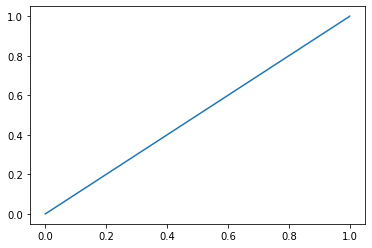

In [37]:
# # 预测
modelnew2 = load_model('./models/model2-27.hdf5')
predict_label2 = modelnew2.predict(test_index)
fpr,tpr,thr = roc_curve(test_label,modelnew2.predict(test_index), pos_label=1)
auc2 = auc(fpr,tpr)
plt.plot(fpr,tpr)
loss2, acc2 = modelnew2.evaluate(test_index, test_label, batch_size=32)
loss2, acc2, auc2

# ROC图像绘制以及AUC计算
注：新版本的keras不能运行predict_proba(),会自动修改为predict()

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, auc, plot_roc_curve
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn import datasets
from sklearn.model_selection import train_test_split
#训练样本类别
n_classes = 3
test_score = modelnew1.predict_proba(test_index)
fig, axes = plt.subplots(2,2,figsize=(8,8))
colors = ["r", "g", "b"]
markers = ["o", "^", "v"]
test_label2 = label_binarize(test_label, classes=[-1,0,1])
print(test_score.shape, test_label2.shape)
for i in range(0):
    fpr,tpr,thr = roc_curve(test_label2[:,i], test_score[:,i])
    axes[int(i/2), i%2].plot(fpr,tpr,color=colors[i], marker=markers[i],label="AUC:{:.2f}".format(auc(fpr,tpr)))
    axes[int(i/2),i%2].set_xlabel("FPR")
    axes[int(i/2),i%2].set_ylabel("TPR")
    #axes[int(i/2),i%2].set_title("class_{}".format(modelnew1.classes_[i]))
    axes[int(i/2),i%2].legend(loc="lower right")
print("AUC:",roc_auc_score(test_label2,test_score,multi_class="ovr"))


C:\Users\z2000\AppData\Roaming\Python\Python37\site-packages\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
(9251, 1) (9251, 3)


ValueError: multi_class must be in ('ovo', 'ovr')